In [1]:
import pandas as pd
from pathlib import Path
path_format = "counterfactual_results/nf={n_feats}_l={layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_ss={steering_strength}_rrd={random_resid_direction}_re={random_explanations}_{model_last}"

cfg_ranges = {
    "n_feats": [300],
    "layer": [32],
    "n_train": [5, 10],
    "n_test": [40],
    "n_explanations": [1, 5, 10],
    "steering_strength": [3, 10, 100],
    "random_resid_direction": [True, False],
    "random_explanations": [True, False],
}


base_cfg = {
    "layer": 32,
    "n_feats": 300,
    "n_train": 5,
    "n_test": 40,
    "n_explanations": 1,
    "steering_strength": 10,
    "random_resid_direction": False,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
}

# load all results
def load_result(cfg):
    path = path_format.format(**cfg)
    
    path = Path(path) / "generations_scores.json"
    df = pd.read_json(path)
    df = df.sort_values(by="max_delta_conditional_entropy", ascending=False)
    return df
base_df = load_result(base_cfg)
base_df

,feat_idx,scorer_examples,completions,explainer_intervention_examples,explanations,explainer_prompts,explainer_examples,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy
158,223,"[[ in right, 30.671875], [, 15.0390625], [, 11...","[{'text': ' in right', 'max_act': 30.671875, '...",[{'prompt': ' and Junior Duck Appreciation Nig...,[finance],"[ and Junior Duck Appreciation Night. Also, fa...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'finance': 1.4792536855},{'finance': 0.2506308},1.479254
3,6,[[ will be two significant benefits for Canada...,[{'text': ' will be two significant benefits f...,[{'prompt': ' of modern life in these United S...,[adjectives],[ of modern life in these United States and th...,"[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'adjectives': 1.3913815676999999},{'adjectives': 0.2657997345},1.391382
76,109,"[[ replacement just like a lightbulb, nomatter...","[{'text': ' replacement just like a lightbulb,...","[{'prompt': ' you‘', 'top_p_increases': [0.004...",[pronouns],"[ you‘, is silly, let's get back to work."" So...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'pronouns': 1.1984810828999999},{'pronouns': 0.21147035790000002},1.198481
143,204,[[ Market]] from the advancing [[orcs]]. He at...,[{'text': ' Market]] from the advancing [[orcs...,"[{'prompt': ', when it comes down to what happ...",[negative],"[, when it comes down to what happens next, af...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'negative': 0.9393657684000001},{'negative': 0.2192734919},0.939366
192,271,"[[<bos>83, 33.09375], [. Hilburn, D by ...\nww...","[{'text': '<bos>83', 'max_act': 33.09375, 'com...","[{'prompt': '.""Muhammad Ali...Anonymous Coward...",[numbers],"[.""Muhammad Ali...Anonymous CowardUser ID: 1, ...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'numbers': 0.9350950003},{'numbers': 0.2575471974},0.935095
...,...,...,...,...,...,...,...,...,...,...,...
29,43,[[ us with their telephone numbers online may ...,[{'text': ' us with their telephone numbers on...,"[{'prompt': ' to pay, or which\nunder the cred...",[legalese<|end_of_text|><|begin_of_text|>-1.0-...,"[ to pay, or which\nunder the credit line deed...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'legalese<|end_of_text|><|begin_of_text|>-1.0...,{'legalese<|end_of_text|><|begin_of_text|>-1.0...,-0.425774
125,179,"[[ pain, nipple thickening or discharge, or, 1...","[{'text': ' pain, nipple thickening or dischar...",[{'prompt': 'see yesterday's federal court rul...,[health],[see yesterday's federal court ruling) that th...,"[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'health': -0.4566351652},{'health': 0.1829897053},-0.456635
114,162,[[ breakfast buffet. The hotel meeting rooms c...,[{'text': ' breakfast buffet. The hotel meetin...,"[{'prompt': '', 'top_p_increases': [0.00996080...",[text],"[, <bos> Kitts Thing To Do\nOverview: This is ...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'text': -0.4668325186},{'text': 0.206377425},-0.466833
37,52,"[[ be provided for 6,500 authors in the, 20.68...","[{'text': ' be provided for 6,500 authors in t...","[{'prompt': ' 1805 1850', 'top_p_increases': [...",[numbers],"[ 1805 1850, seconds, Plants for the Combine...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'numbers': -0.47254318},{'numbers': 0.18281450740000002},-0.472543


In [2]:
def get_sem_normalized_scores(df):
    def get_z_score(row):
        scores_by_expls = row["delta_conditional_entropy_by_explanation"]
        sems_by_expl = row["delta_conditional_entropy_sems_by_explanation"]
        best_expl = max(scores_by_expls, key=lambda x: scores_by_expls[x])
        best_score = scores_by_expls[best_expl]
        best_sem = sems_by_expl[best_expl]
        z_score = best_score / best_sem
        return z_score
    df["sem_normalized_max_delta_conditional_entropy"] = df.apply(get_z_score, axis=1)
    return df

base_df = get_sem_normalized_scores(base_df)
base_df

,feat_idx,scorer_examples,completions,explainer_intervention_examples,explanations,explainer_prompts,explainer_examples,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,sem_normalized_max_delta_conditional_entropy
158,223,"[[ in right, 30.671875], [, 15.0390625], [, 11...","[{'text': ' in right', 'max_act': 30.671875, '...",[{'prompt': ' and Junior Duck Appreciation Nig...,[finance],"[ and Junior Duck Appreciation Night. Also, fa...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'finance': 1.4792536855},{'finance': 0.2506308},1.479254,5.902123
3,6,[[ will be two significant benefits for Canada...,[{'text': ' will be two significant benefits f...,[{'prompt': ' of modern life in these United S...,[adjectives],[ of modern life in these United States and th...,"[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'adjectives': 1.3913815676999999},{'adjectives': 0.2657997345},1.391382,5.234699
76,109,"[[ replacement just like a lightbulb, nomatter...","[{'text': ' replacement just like a lightbulb,...","[{'prompt': ' you‘', 'top_p_increases': [0.004...",[pronouns],"[ you‘, is silly, let's get back to work."" So...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'pronouns': 1.1984810828999999},{'pronouns': 0.21147035790000002},1.198481,5.667372
143,204,[[ Market]] from the advancing [[orcs]]. He at...,[{'text': ' Market]] from the advancing [[orcs...,"[{'prompt': ', when it comes down to what happ...",[negative],"[, when it comes down to what happens next, af...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'negative': 0.9393657684000001},{'negative': 0.2192734919},0.939366,4.283991
192,271,"[[<bos>83, 33.09375], [. Hilburn, D by ...\nww...","[{'text': '<bos>83', 'max_act': 33.09375, 'com...","[{'prompt': '.""Muhammad Ali...Anonymous Coward...",[numbers],"[.""Muhammad Ali...Anonymous CowardUser ID: 1, ...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'numbers': 0.9350950003},{'numbers': 0.2575471974},0.935095,3.630771
...,...,...,...,...,...,...,...,...,...,...,...,...
29,43,[[ us with their telephone numbers online may ...,[{'text': ' us with their telephone numbers on...,"[{'prompt': ' to pay, or which\nunder the cred...",[legalese<|end_of_text|><|begin_of_text|>-1.0-...,"[ to pay, or which\nunder the credit line deed...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'legalese<|end_of_text|><|begin_of_text|>-1.0...,{'legalese<|end_of_text|><|begin_of_text|>-1.0...,-0.425774,-1.397557
125,179,"[[ pain, nipple thickening or discharge, or, 1...","[{'text': ' pain, nipple thickening or dischar...",[{'prompt': 'see yesterday's federal court rul...,[health],[see yesterday's federal court ruling) that th...,"[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'health': -0.4566351652},{'health': 0.1829897053},-0.456635,-2.495415
114,162,[[ breakfast buffet. The hotel meeting rooms c...,[{'text': ' breakfast buffet. The hotel meetin...,"[{'prompt': '', 'top_p_increases': [0.00996080...",[text],"[, <bos> Kitts Thing To Do\nOverview: This is ...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'text': -0.4668325186},{'text': 0.206377425},-0.466833,-2.262033
37,52,"[[ be provided for 6,500 authors in the, 20.68...","[{'text': ' be provided for 6,500 authors in t...","[{'prompt': ' 1805 1850', 'top_p_increases': [...",[numbers],"[ 1805 1850, seconds, Plants for the Combine...","[[er V, Fuchs H, de Angelis MH, Neschen S. Mol...","{'explanation': None, 'intervention_examples':...",{'numbers': -0.47254318},{'numbers'

In [3]:
import matplotlib.pyplot as plt

cfg = base_cfg.copy()
case_cfg = base_cfg.copy()
case_cfg["random_explanations"] = True

case_df = get_sem_normalized_scores(load_result(case_cfg))
control_df = get_sem_normalized_scores(load_result(cfg))
case_df.set_index("feat_idx", inplace=True)
control_df.set_index("feat_idx", inplace=True)

# case_scores = case_df["max_delta_conditional_entropy"].values
# control_scores = control_df["max_delta_conditional_entropy"].values
case_scores = case_df["sem_normalized_max_delta_conditional_entropy"].values
control_scores = control_df["sem_normalized_max_delta_conditional_entropy"].values

diff_key = [k for k in case_cfg.keys() if case_cfg[k] != cfg[k]][0]
plt.title(f"{diff_key} = {case_cfg[diff_key]} (control: {cfg[diff_key]})")
plt.hist(case_scores, bins=20, alpha=0.5, label="case", density=True)
plt.hist(control_scores, bins=20, alpha=0.5, label="control", density=True)
plt.xlabel("Sem normalized max delta conditional entropy")
plt.ylabel("Density")
plt.legend()
plt.show()



FileNotFoundError: File counterfactual_results/nf=300_l=32_nt=5_nt=40_ne=1_ss=10_rrd=False_re=True_gemma-2-9b/generations_scores.json does not exist

In [92]:
# join on feat_idx

joined_df = control_df.join(case_df, rsuffix="_case", how="inner")
len(joined_df), len(control_df), len(case_df)

(214, 214, 214)

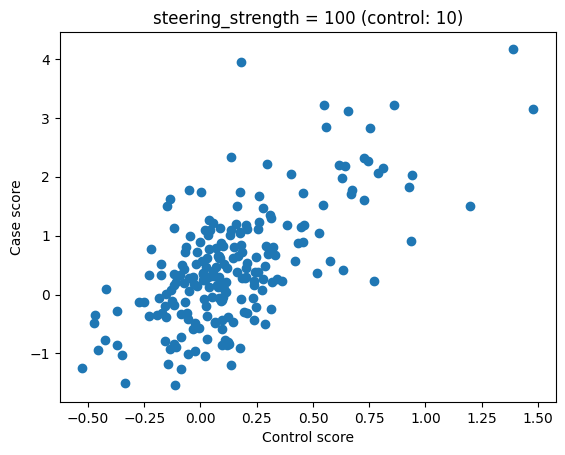

In [93]:
plt.scatter(joined_df["max_delta_conditional_entropy"], joined_df["max_delta_conditional_entropy_case"])
plt.xlabel("Control score")
plt.ylabel("Case score")
plt.title(f"{diff_key} = {case_cfg[diff_key]} (control: {cfg[diff_key]})")
plt.show()
